<a href="https://colab.research.google.com/github/Biski7/NeuralNetworks/blob/main/Intro_to_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Converting MNIST Image Files to Tensor of 4D ( Number, Height, Width, Channels)
transform_image = transforms.ToTensor()

# Import the data
train_data = datasets.MNIST(root='/CNN_example', train=True, download=True, transform=transform_image) # Downloading and Saving the file
test_data = datasets.MNIST(root='/CNN_example', train=False, download=True, transform=transform_image) # Downloading and Saving the file

100%|██████████| 9912422/9912422 [00:00<00:00, 109781869.19it/s]


Extracting /CNN_example/MNIST/raw/train-images-idx3-ubyte.gz to /CNN_example/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32046479.85it/s]


Extracting /CNN_example/MNIST/raw/train-labels-idx1-ubyte.gz to /CNN_example/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27617168.74it/s]


Extracting /CNN_example/MNIST/raw/t10k-images-idx3-ubyte.gz to /CNN_example/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5549236.46it/s]


Extracting /CNN_example/MNIST/raw/t10k-labels-idx1-ubyte.gz to /CNN_example/MNIST/raw



In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /CNN_example
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /CNN_example
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
# Defining the CNN Model
# Conv3d(input, output, kernel, stride)
# conv_1 = nn.Conv2d(1, 6, 3, 1)
# conv_2 = nn.Conv2d(6, 12, 3, 1)

In [ ]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Creating a Fully Connected Layer with 120 outputs and inputs as per previous output
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    # 10 layers in the output
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # Using 2*2 kernel and stride of 2
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # Flatten the output using view
    X = X.view(-1, 16*5*5) # -1 because it will automatically resize to correct size ( useful when we change the batch later )

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)

In [ ]:
# Create an instance of the Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

# Create Variables to Track Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  #Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # To start the batch at 1 not 0
    y_pred = model(X_train) # No need to flatten the input image as our first Convolution layer is expecting 2d data
    loss = criterion(y_pred, y_train)
    # print(y_pred)
    predicted = torch.max(y_pred.data, 1) [1] # adding up the number of correct predictions
    batch_corr = (predicted == y_train).sum() # determine how many we got correct from this batch
    trn_corr += batch_corr

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the results
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad():  # No gradient so we don't update out weights and bias for the test dataset (test only once)
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


stop_time = time.time()
total = stop_time - start_time
print(f'Training: {total/60} minutes')

Epoch: 0 Batch: 600 Loss: 0.1623610556125641
Epoch: 0 Batch: 1200 Loss: 0.1502392590045929
Epoch: 0 Batch: 1800 Loss: 0.4744560718536377
Epoch: 0 Batch: 2400 Loss: 0.14238706231117249
Epoch: 0 Batch: 3000 Loss: 0.007758188061416149
Epoch: 0 Batch: 3600 Loss: 0.3836284875869751
Epoch: 0 Batch: 4200 Loss: 0.0038223876617848873
Epoch: 0 Batch: 4800 Loss: 0.0021286322735249996
Epoch: 0 Batch: 5400 Loss: 0.0569545142352581
Epoch: 0 Batch: 6000 Loss: 0.00038789428072050214
Epoch: 1 Batch: 600 Loss: 0.005851339548826218
Epoch: 1 Batch: 1200 Loss: 0.3855525553226471
Epoch: 1 Batch: 1800 Loss: 0.004819948226213455
Epoch: 1 Batch: 2400 Loss: 0.003216963727027178
Epoch: 1 Batch: 3000 Loss: 0.0332382395863533
Epoch: 1 Batch: 3600 Loss: 0.5372857451438904
Epoch: 1 Batch: 4200 Loss: 0.04561494290828705
Epoch: 1 Batch: 4800 Loss: 0.0007510822033509612
Epoch: 1 Batch: 5400 Loss: 0.0001173773780465126
Epoch: 1 Batch: 6000 Loss: 0.14201366901397705
Epoch: 2 Batch: 600 Loss: 0.023733172565698624
Epoch: 2

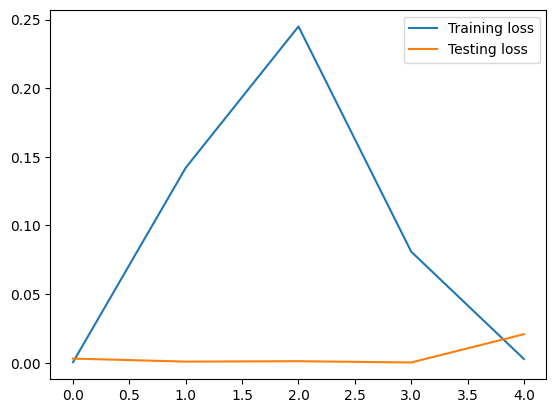

In [ ]:
# Plotting the loss
train_losses = [tl.item() for tl in train_losses] # Changing tensor to pandas numpy
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Testing loss")
plt.legend()
plt.show()

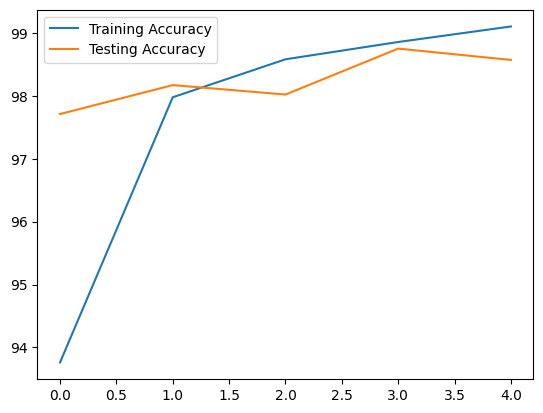

In [ ]:
# Plotting the accuracy at end of each training epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Testing Accuracy")
plt.legend()
plt.show()

In [ ]:
test_load1 = DataLoader(test_data, batch_size = 10000, shuffle=False)
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load1:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [ ]:
correct.item()/len(test_data) * 100

98.57000000000001